In [41]:
!nvidia-smi

Sun Jun 29 13:42:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             32W /   70W |    1158MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [42]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2025-06-29 13:42:56--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap [following]
--2025-06-29 13:42:57--  https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc70288d7e07c641e5143b996296.dl.dropboxusercontent.com/cd/0/inline/Csj0Ds1FX--7ojuEDs0K2xqJq1x9qO5-1_D19ox-mo1_WQpHa3oro-CCXTNmfynwV7qDefVVEReiOQfzpWNKg-6ElBuI-2BN0k66Pgl5lwLbpVxFKm8m0qIJejlr4ijOUxVlhMhS0wi9UmGMl0WA-TC8/file# [following]
--2025-06-29 13:42:57--  https://uc70288d7e07c641e5143b996296.dl.dropboxusercontent.com/cd/0/inline/C

In [43]:
!unzip -q "/content/archive.zip"

replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test/angry/PrivateTest_10304478.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [44]:
#Import required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [45]:
#Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [46]:
#Getting Image paths
train_image_paths = list(train_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), train_image_paths))

train_image_paths[:10]

[PosixPath('/content/train/angry/Training_85784799.jpg'),
 PosixPath('/content/train/angry/Training_54878698.jpg'),
 PosixPath('/content/train/angry/Training_76013291.jpg'),
 PosixPath('/content/train/angry/Training_57850656.jpg'),
 PosixPath('/content/train/angry/Training_9436506.jpg'),
 PosixPath('/content/train/angry/Training_93872864.jpg'),
 PosixPath('/content/train/angry/Training_20661113.jpg'),
 PosixPath('/content/train/angry/Training_3415081.jpg'),
 PosixPath('/content/train/angry/Training_32897989.jpg'),
 PosixPath('/content/train/angry/Training_8489443.jpg')]

In [47]:
#Getting their respective labels

def get_label(image_path):
  return str(image_path).split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x), train_image_paths))
train_image_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

In [48]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_image_labels)
train_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
train_image_labels = tf.keras.utils.to_categorical(train_labels)
train_image_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [50]:
from sklearn.model_selection import train_test_split
paths, Val_paths, train_labels, Val_labels = train_test_split(train_image_paths, train_image_labels, test_size=0.2)

In [51]:
#Compute class weights
classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals
classWeight = {e : weight for e, weight in enumerate(classWeight.flatten())}
print(classWeight)

{0: np.float64(1.8197802197802198), 1: np.float64(17.457831325301203), 2: np.float64(1.7779141104294478), 3: np.float64(1.0), 4: np.float64(1.4493623405851463), 5: np.float64(1.511342894393742), 6: np.float64(2.2640625)}


In [52]:
#Function used for Transformation
def load(image, label):
  image = tf.io.read_file(image)
  image = tf.image.decode_jpeg(image, channels=3)
  return image, label

In [53]:
#Data Augmentation
#Define Image size and batch size
import tensorflow as tf
IMG_SIZE = 96
BATCH_SIZE = 32

#Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE) # Changed from tf.keras.layers.experimental.preprocessing.Resizing
])

#Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # Changed from tf.keras.layers.experimental.preprocessing.RandomFlip
    tf.keras.layers.RandomRotation(0.1), # Changed from tf.keras.layers.experimental.preprocessing.RandomRotation
    tf.keras.layers.RandomZoom(height_factor = (-0.1, -0.05)) # Changed from tf.keras.layers.experimental.preprocessing.RandomZoom
])

In [54]:
#Function used to create a Tensorflow Data Object
AUTOTUNE = tf.data.AUTOTUNE
def get_dataset(paths, labels, training=True):
  # Convert PosixPath objects to strings before creating the tensor
  image_paths = tf.convert_to_tensor([str(path) for path in paths])
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

  dataset = dataset.map(lambda image, label : load(image, label))
  dataset = dataset.map(lambda image, label: (resize(image), label), num_parallel_calls=AUTOTUNE)
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(BATCH_SIZE)

  if training:
    dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls=AUTOTUNE)

  dataset = dataset.repeat()
  return dataset

In [55]:
#Creating Train Dataset object and verifying it
train_dataset = get_dataset(paths, train_labels) # Removed %time
%time next(iter(train_dataset)) #Added %time here to check performance if required.

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 519 ms, sys: 132 ms, total: 651 ms
Wall time: 434 ms
(32, 96, 96, 3)
(32, 7)


angry


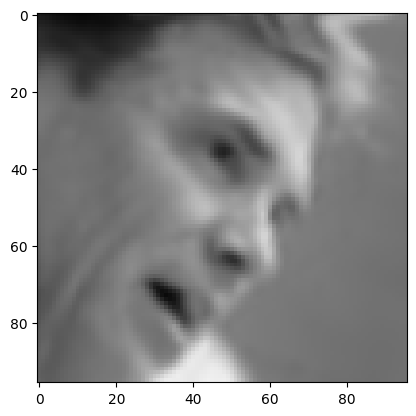

In [56]:
#View a sample Training Image
print(le.inverse_transform(np.argmax(label , axis =1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

In [57]:
%time val_dataset = get_dataset(Val_paths, Val_labels, training=False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 43.2 ms, sys: 10 µs, total: 43.2 ms
Wall time: 43 ms
(32, 96, 96, 3)
(32, 7)


In [58]:
#Building EfficientNet Model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape = (96, 96, 3),
    include_top = False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 3, 3, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,824 (30.33 MB)

 Trainable params: 7,882,249 (30.07 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [59]:
#Compiling model by providing the Optimizer, Loss and Metrics
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
#Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(paths) // BATCH_SIZE,
    epochs = 25,
    validation_data = val_dataset,
    validation_steps = len(Val_paths) // BATCH_SIZE,
    class_weight = classWeight,
    callbacks = [checkpoint, earlystop] # Added callbacks here
)

Epoch 1/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3308 - loss: 3.0647 - precision: 0.5845 - recall: 0.1202
Epoch 1: val_loss improved from inf to 1.42898, saving model to best_weight.weights.h5
717/717 ━━━━━━━━━━━━━━━━━━━━ 184s 103ms/step - accuracy: 0.3309 - loss: 3.0644 - precision: 0.5847 - recall: 0.1203 - val_accuracy: 0.4508 - val_loss: 1.4290 - val_precision: 0.6813 - val_recall: 0.2903
Epoch 2/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4825 - loss: 2.4054 - precision: 0.7076 - recall: 0.2723
Epoch 2: val_loss did not improve from 1.42898
717/717 ━━━━━━━━━━━━━━━━━━━━ 119s 87ms/step - accuracy: 0.4825 - loss: 2.4054 - precision: 0.7075 - recall: 0.2724 - val_accuracy: 0.4544 - val_loss: 1.4480 - val_precision: 0.6059 - val_recall: 0.2748
Epoch 3/25
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5106 - loss: 2.2719 - precision: 0.7077 - recall: 0.3094
Epoch 3: val_loss improved from 1.42898 to 1.25038, saving model to best_weight.weights.h

In [ ]:
model.layers[0].trainable = False

In [ ]:
#Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_weight.weights.h5",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True
)
earlystop = tf.keras.callbacks.EarlyStopping(patience = 4)

In [ ]:
model.load_weights("best_weight.weights.h5")

In [ ]:
#Crate a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x : get_label(x), test_image_paths))

test_labels = le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)
test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [96, 96], method="bilinear")
  return image, label

test_dataset = (
  tf.data.Dataset
  .from_tensor_slices((test_image_paths, test_labels))
  .map(decode_image)
  .batch(BATCH_SIZE)
)

In [ ]:
#Verify Test Dataset Object
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

In [ ]:
#View a sample Validation Image
print(le.inverse_transform(np.argmax(label , axis =1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

In [ ]:
#Evaluating the loading model
loss,  acc, prec, rec = model.evaluate(test_dataset)
#Evaluating the loading model
loss,  acc, prec, rec = model.evaluate(test_dataset)
print("Testing Accuracy: {:.2f}%".format(acc * 100))
print("Testing Precision: {:.2f}%".format(prec * 100))
print("Testing Recall: {:.2f}%".format(rec * 100))

In [ ]:
#Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
#Save Label Encoder
import pickle
def save_object(obj , name):
  pickle_obj = open(f"{name}.pkl" , "wb")
  pickle.dump(obj , pickle_obj)
  pickle_obj.close()

In [ ]:
# @title Default title text
save_object(le, "LabelEncoder")

In [ ]:
def plot_training_history(history):
    metrics = ['accuracy', 'precision', 'recall']

    plt.figure(figsize=(18, 5))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        plt.plot([x * 100 for x in history.history[metric]], label=f'Train {metric}')
        plt.plot([x * 100 for x in history.history[f'val_{metric}']], label=f'Val {metric}')
        plt.xlabel("Epochs")
        plt.ylabel(f"{metric.capitalize()} (%)")
        plt.title(f'Train vs Val {metric.capitalize()}')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)